In [33]:
from __future__ import division
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import odeint
from tqdm import tqdm
import scipy.stats as st
import pandas as pd

| Player | Hawk | Dove |
|:------:|:----:|:----:|
| Hawk | ((G-C)/2, (G-C)/2 ) | (G, 0) |
| Dove | (0, G) | ( G/2, G/2) |

where $G$ is the gain and $C$ is the cost. The replicator dynamics of this two player system is written as

\begin{align}
    & \dot{x}_1 = r_1(\vec{x}, A) x_1 - \left \langle r \right \rangle (\vec{x}, A) x_1 \\
    & \dot{x}_2 = r_2(\vec{x}, A) x_2 - \left \langle r \right \rangle (\vec{x}, A) x_2
\end{align}

since $x_1 + x_2 = 1$, we only need one variable $x$ to describe the population.

## Limited fights

In [3]:
def hd_model(x, t, pars):
    r1=x*pars['A'][0,0]+(1-x)*pars['A'][0,1]
    r2=x*pars['A'][1,0]+(1-x)*pars['A'][1,1]
    r_avg=r1*x + r2*(1-x)
    dxdt= r1*x - r_avg*x
    return dxdt

In [8]:
G = 10
C = 2
A = np.array([[(G-C)/2, G],
              [0, G/2]])
x0 = 0.1
t_max = 4
t = np.linspace(0,t_max,10*t_max)

pars = {}
pars['A'] = A
pars['C'] = C
pars['G'] = G

In [7]:
x =odeint(hd_model, x0, t, args=(pars,))

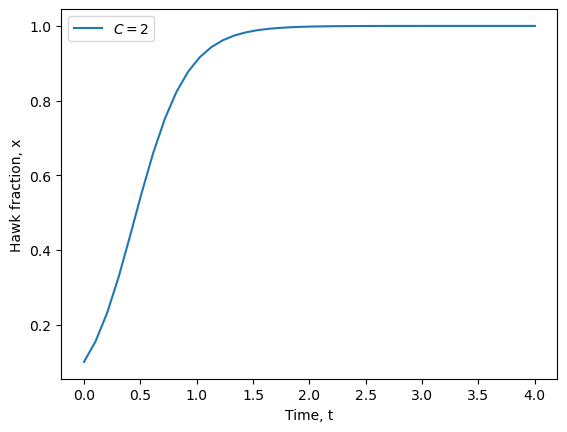

In [10]:
plt.plot(t,x,label=r'$C={cost}$'.format(cost=pars['C']))
plt.xlabel('Time, t')
plt.ylabel('Hawk fraction, x')
plt.legend()
plt.show()

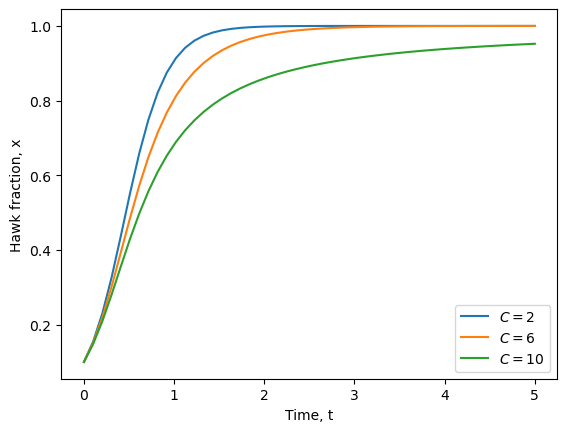

In [14]:
fig, ax = plt.subplots()
for i in range(3):
    G = 10
    C = 2*(2*i+1)
    A = np.array([[(G-C)/2, G],
                  [0, G/2]])
    x0 = 0.1
    t_max = 5
    t= np.linspace(0,t_max,10*t_max)

    pars = {}
    pars['A'] = A
    pars['C'] = C
    
    x = odeint(hd_model, x0, t, args=(pars,))
    
    plt.plot(t,x,label=r'$C={cost}$'.format(cost=pars['C']))

plt.xlabel('Time, t')
plt.ylabel('Hawk fraction, x')
plt.legend(loc = 'lower right')
plt.show()

## Costly fights and convergence

In [15]:
def hd_model(x, t, pars):
    r1=x*pars['A'][0,0]+(1-x)*pars['A'][0,1]
    r2=x*pars['A'][1,0]+(1-x)*pars['A'][1,1]
    r_avg=r1*x + r2*(1-x)
    dxdt= r1*x - r_avg*x
    return dxdt

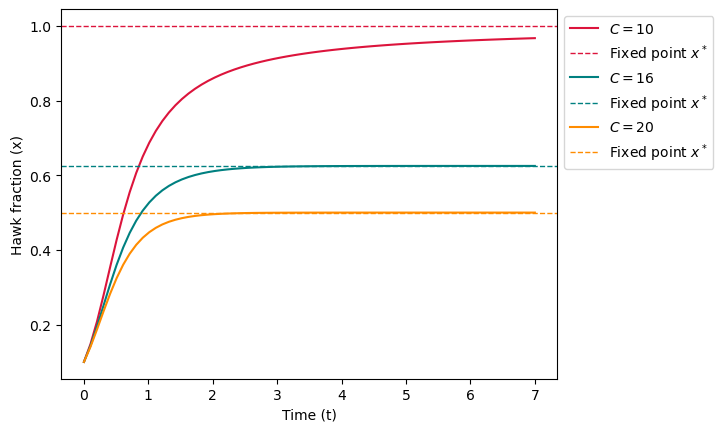

In [30]:
fig, ax = plt.subplots()

colors = ['crimson', 'teal', 'darkorange']

idx = -1
for i in [10,16,20]:
    idx += 1
    G = 10
    C = i
    A = np.array([[(G-C)/2, G],
                  [0, G/2]])
    x0 = 0.1
    t_max = 7
    t= np.linspace(0,t_max,10*t_max)

    pars = {}
    pars['A'] = A
    pars['C'] = C
    pars['G'] = G
    
    x = odeint(hd_model, x0, t, args=(pars,))
    
    plt.plot(t,x,label=r'$C={cost}$'.format(cost=pars['C']), color = colors[idx])
    plt.axhline(pars['G']/pars['C'], lw = 1, ls = '--', label = 'Fixed point $x^*$',
               color = colors[idx])

plt.xlabel('Time (t)')
plt.ylabel('Hawk fraction (x)')
plt.legend(bbox_to_anchor = (1, 1), ncol = 1)
plt.show()

## Stochastic version of microbial games

In [2]:
pars={}
pars['N']=1000
pars['G']=10
pars['C']=16
pars['A']=np.array([[(pars['G']-pars['C'])/2, pars['G']],
                    [0, pars['G']/2]])
pars['x0vals'] = [0.1, 0.9]
pars['num_iter']=500
pars['dt']=0.01
pars['tmax']=pars['dt']*pars['num_iter']

In [3]:
# 0 refers to hawks
# 1 refers to doves

curx = 0.9

p1=np.random.uniform()<curx
tmpid1=1-(p1==1)
p2=np.random.uniform()<curx
tmpid2=1-(p2==1)

In [4]:
payoff = pars['A'][tmpid1,tmpid2]

In [5]:
payoff

10.0

In [6]:
if payoff>0:
    birth = np.random.uniform() < payoff*pars['dt']
    if birth:
        replace_dove = np.random.uniform() >= curx
        if replace_dove:
            curx = curx+1/pars['N']

In [7]:
#Initialize
pars={}
pars['N']=1000
pars['G']=10
pars['C']=16
pars['A']=np.array([[(pars['G']-pars['C'])/2, pars['G']],
                    [0, pars['G']/2]])
pars['x0'] = 0.9
pars['num_iter']=500
pars['dt']=0.01
pars['tmax']=pars['dt']*pars['num_iter']

stats={}
curx = pars['x0']
x=[curx]
t=[0]
#Run for each time
for i in tqdm(range(pars['num_iter'])):
    #Run for each player
    for j in range(pars['N']):
        p1 = np.random.uniform()<curx #Identity of player 1
        tmpid1 = 1-(p1==1) #In payoff matrix: hawk is 0, dove is 1
        p2 = np.random.uniform()<curx #Identity of player 2
        tmpid2 = 1-(p2==1) #In payoff matrix: hawk is 0, dove is 1
        #Game cases
        if p1==1: #Hawk
            payoff = pars['A'][tmpid1,tmpid2]
            if payoff>0: #Hawk may give birth
                birth = np.random.uniform() < payoff*pars['dt']
                if birth:
                    replace_dove = np.random.uniform() >= curx
                    if replace_dove:
                        curx = curx+1/pars['N']
            elif payoff < 0: #Hawk may die
                death = np.random.uniform() < -payoff*pars['dt']
                if death:
                    replace_hawk = np.random.uniform() < curx
                    if replace_hawk:
                        curx = curx-1/pars['N']

        else: #p1 is dove
            payoff = pars['A'][tmpid1,tmpid2]
            if payoff > 0: #Dove may give birth
                birth = np.random.uniform() < payoff*pars['dt']
                if birth:
                    replace_hawk = np.random.uniform() < curx
                    if replace_hawk:
                        curx = curx-1/pars['N']
            elif payoff < 0: #Dove may die
                death = np.random.uniform() < -payoff*pars['dt']
                if death:
                    replace_dove = np.random.uniform() >= curx
                    if replace_dove:
                        curx = curx+1/pars['N']
    #After looping through all N players
    x.append(curx)
    t.append(t[-1]+pars['dt'])

stats['x']=np.array(x)
stats['t']=np.array(t)

100%|██████████| 500/500 [00:03<00:00, 144.53it/s]


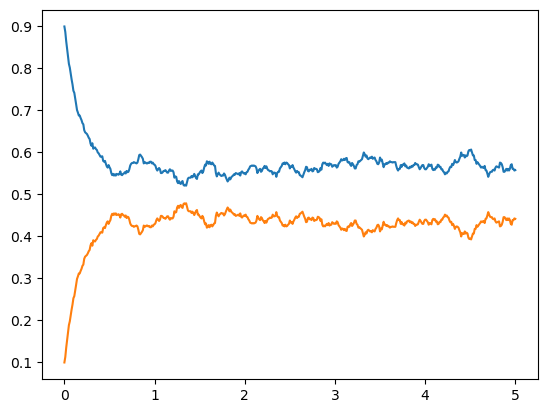

In [8]:
plt.plot(stats['t'], stats['x'])
plt.plot(stats['t'], 1 - stats['x'])
plt.show()

In [9]:
#Initialize
final_pop_hawks = []

for k in tqdm(range(200)):
    pars={}
    pars['N'] = 1000
    pars['G'] = 10
    pars['C'] = 8
    pars['A'] = np.array([[(pars['G']-pars['C'])/2, pars['G']],
                        [0, pars['G']/2]])
    pars['x0'] = 0.005
    pars['num_iter']=500
    pars['dt']=0.01
    pars['tmax']=pars['dt']*pars['num_iter']
    
    curx = pars['x0']
    x=[curx]
    t=[0]
    #Run for each time
    for i in range(pars['num_iter']):
        #Run for each player
        for j in range(pars['N']):
            p1 = np.random.uniform()<curx #Identity of player 1
            tmpid1 = 1-(p1==1) #In payoff matrix: hawk is 0, dove is 1
            p2 = np.random.uniform()<curx #Identity of player 2
            tmpid2 = 1-(p2==1) #In payoff matrix: hawk is 0, dove is 1
            #Game cases
            if p1==1: #Hawk
                payoff = pars['A'][tmpid1,tmpid2]
                if payoff>0: #Hawk may give birth
                    birth = np.random.uniform() < payoff*pars['dt']
                    if birth:
                        replace_dove = np.random.uniform() >= curx
                        if replace_dove:
                            curx = curx+1/pars['N']
                elif payoff < 0: #Hawk may die
                    death = np.random.uniform() < -payoff*pars['dt']
                    if death:
                        replace_hawk = np.random.uniform() < curx
                        if replace_hawk:
                            curx = curx-1/pars['N']

            else: #p1 is dove
                payoff = pars['A'][tmpid1,tmpid2]
                if payoff > 0: #Dove may give birth
                    birth = np.random.uniform() < payoff*pars['dt']
                    if birth:
                        replace_hawk = np.random.uniform() < curx
                        if replace_hawk:
                            curx = curx-1/pars['N']
                elif payoff < 0: #Dove may die
                    death = np.random.uniform() < -payoff*pars['dt']
                    if death:
                        replace_dove = np.random.uniform() >= curx
                        if replace_dove:
                            curx = curx+1/pars['N']
        #After looping through all N players
        x.append(curx)
        t.append(t[-1]+pars['dt'])

    final_pop_hawks.append(x[-1])

100%|██████████| 200/200 [13:01<00:00,  3.91s/it]


In [10]:
final_pop_hawks = np.array(final_pop_hawks)

In [11]:
print(f'Hawk extinction probability: {100*len(np.where(final_pop_hawks == 0)[0])/len(final_pop_hawks):.1f} %')

Hawk extinction probability: 1.5 %


## Spatial game

$$ \dot{x} = r_1(\vec{x}, A)x - \left \langle r \right \rangle (\vec{x}, A)x $$

where $x$ is the frequency of the red type VI $\textit{Vibrio}$ cell, and

\begin{align}
    & r_1(x) = G \frac{x}{2} + (1-x)\frac{G - C}{2} \\
    & r_2(x) = (G - C)\frac{x}{2} + (1-x) \frac{G}{2} \\
    & \left \langle r \right \rangle = r_1 x + r_2 (1 - x)
\end{align}

and we may rewrite the replicator dynamics as

\begin{align}
    \dot{x} = x (1 - x)(r_1(x) - r_2(x)) = C x (1 - x) \left( x - \frac{1}{2} \right)
\end{align}

In [12]:
L = 200
x1 = 0.5
x = np.random.choice([0,1],[L,L],[0.5,0.5])

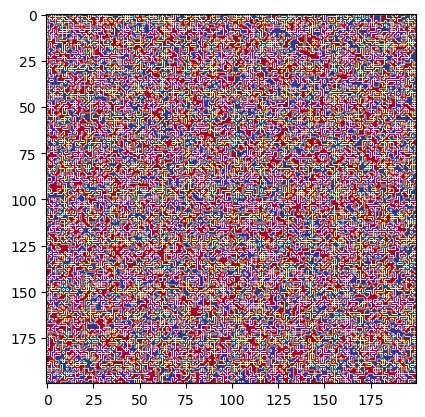

In [14]:
plt.imshow(x,cmap='RdYlBu') # Visualize the habitat
plt.show()

In [15]:
moves = np.array([[-1,0],[1,0],[0,-1], [0,1]])

In [16]:
moves

array([[-1,  0],
       [ 1,  0],
       [ 0, -1],
       [ 0,  1]])

In [24]:
def pbc_reset(opp_pos, L):
    if opp_pos[0] >= L - 1:
        opp_pos[0] = 0
    if opp_pos[1] >= L - 1:
        opp_pos[1] = 0
    return opp_pos

In [27]:
foc_pos = np.random.choice(range(L),[1,2])[0] # Position of focal player
opp_pos = foc_pos + moves[np.random.choice(range(4))]

In [28]:
foc_pos

array([14, 18])

In [29]:
opp_pos

array([14, 17])

In [30]:
opp_pos = pbc_reset(opp_pos,L) # Accounts for PBC-s

In [31]:
opp_pos

array([14, 17])

In [154]:
L = 200
N = L**2
A = np.array([[5,-4],[-4,5]])
x1 = 0.5
num_iter = 501
dt = 0.01
tmax = dt*num_iter
moves = np.array([[-1,0],[1,0],[0,-1], [0,1]])
x = np.random.choice([0,1],[L,L],[0.5,0.5])

In [155]:
len(np.where(x == 0)[0])

20151

In [156]:
len(np.where(x == 1)[0])

19849

In [157]:
len(np.where(x == 0)[0]) + len(np.where(x == 1)[0])

40000

In [158]:
pop_0 = [len(np.where(x == 0)[0])]
gens = [0]
for i in tqdm(range(num_iter)):
    for j in range(N):
        foc_pos = np.random.choice(range(L),[1,2])[0]
        foc_id = x[foc_pos[0], foc_pos[1]]
        opp_pos = foc_pos + moves[np.random.choice(range(4))]
        opp_pos = pbc_reset(opp_pos, L)
        opp_id = x[opp_pos[0], opp_pos[1]]
        payoff = A[foc_id, opp_id]
        if payoff > 0:
            birth = np.random.uniform() < payoff*dt
            if birth:
                rep_pos = foc_pos + moves[np.random.choice(range(4))]
                rep_pos = pbc_reset(rep_pos, L)
                replace = np.random.uniform(0, 1)
                if replace <= len(np.where(x == foc_id)[0]):
                    x[rep_pos[0], rep_pos[1]] = foc_id
        elif payoff < 0:
            death = np.random.uniform() < np.abs(payoff)*dt
            if death:
                rep_pos = foc_pos + moves[np.random.choice(range(4))]
                rep_pos = pbc_reset(rep_pos ,L)
                replace = np.random.uniform(0, 1)
                if replace > len(np.where(x == foc_id)[0]):
                    x[foc_pos[0], foc_pos[1]] = opp_id
    
    pop_0.append(len(np.where(x == 0)[0]))
    gens.append(i+1)
    if i % 10 == 0:
        fig, ax = plt.subplots(1, 2, figsize = (9,4))
        ax[0].axis('off')
        ax[0].set_title('Spatial distribution')
        ax[0].contourf(x, cmap='inferno', levels = 2)
        # plt.savefig('Gen %d'%i, dpi=300)
        
        ax[1].plot(gens, pop_0, color = sns.color_palette('inferno')[1])
        ax[1].plot(gens, 200**2 - np.array(pop_0), color = sns.color_palette('inferno')[4])
        ax[1].set_xlabel('Generations')
        ax[1].set_ylabel('Populations')
        ax[1].set_ylim(18000, 22000)
        ax[1].set_xlim(0, 500)
        ax[1].set_title('Populations over generations')
        
        fig.text(0.5, 1.03, 'Gen %d'%i, fontsize = 16, ha = 'center')
        
        plt.tight_layout()
        plt.savefig(f'Gifs/Cell_patter_gen_{i}.png', dpi = 300, bbox_inches = 'tight')
        # plt.show()
        plt.close()

100%|██████████| 501/501 [29:26<00:00,  3.53s/it]
